In [1]:
# Install only if needed outside notebook setup
# !pip install transformers==4.22.1 -q

# General Imports
import gc
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly (optional, for interactive plots)
from plotly.offline import iplot

# Machine Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# HuggingFace Transformers
from transformers import DistilBertTokenizer, DistilBertModel

from transformers import TFAutoModel


# Tensorflow Keras

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
import sys
print(sys.executable)

C:\Users\prish\anaconda3\envs\tfenvironment\python.exe


In [3]:
# Load dataset
df = pd.read_csv("datasets/labelled.csv")
print(f"Dataset shape: {df.shape}")
display(df.head())

# Add word count column (vectorized)
df['count'] = df['Body'].str.split().str.len()

# Category mapping
category_map = {
    "Entertainment": 0, "Business": 1, "Politics": 2, "Judiciary": 3, "Crime": 4,
    "Culture": 5, "Sports": 6, "Science": 7, "International": 8, "Technology": 9
}
df['Category_encoded'] = df['Category'].map(category_map)

print("\nCategory Mapping:\n", category_map)


Dataset shape: (11583, 4)


,Heading,Body,Category,URL
0,free speech not hate speech madras high court ...,madras high court issue significant remark ami...,Judiciary,https://www.indiatoday.in/law/high-courts/stor...
1,comment take context say us cop mock indian st...,seattle police officer guild friday come defen...,Crime,https://www.indiatoday.in/world/story/indian-s...
2,first meeting one nation one election committe...,first official meeting one nation one election...,Politics,https://www.indiatoday.in/india/story/one-nati...
3,us airlines flight depressurize midair plummet...,united airlines jet head rome turn around less...,Crime,https://www.indiatoday.in/world/story/us-fligh...
4,terrorist kill security force foil infiltratio...,three terrorist kill infiltration bid foil sec...,Crime,https://www.indiatoday.in/india/story/one-terr...



Category Mapping:
 {'Entertainment': 0, 'Business': 1, 'Politics': 2, 'Judiciary': 3, 'Crime': 4, 'Culture': 5, 'Sports': 6, 'Science': 7, 'International': 8, 'Technology': 9}


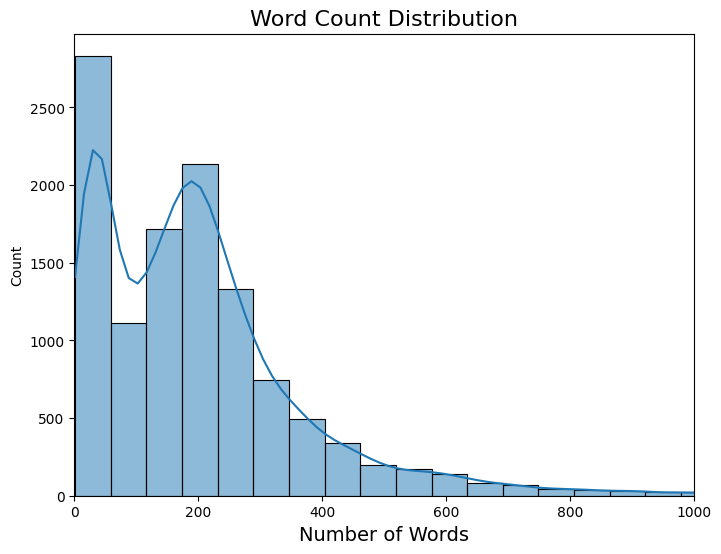

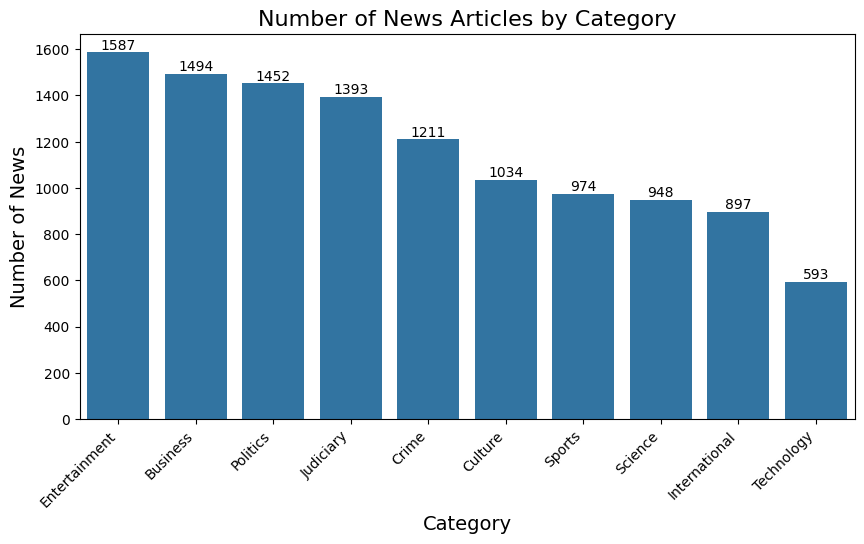

In [4]:
# Word count distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['count'], bins=50, kde=True)
plt.xlim(0, 1000)
plt.xlabel('Number of Words', fontsize=14)
plt.title('Word Count Distribution', fontsize=16)
plt.show()

# News count by category
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of News', fontsize=14)
plt.title('Number of News Articles by Category', fontsize=16)
plt.show()


In [5]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_texts(texts, max_length=512):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

encodings = tokenize_texts(df['Body'])
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']




In [6]:
print(df.columns)


Index(['Heading', 'Body', 'Category', 'URL', 'count', 'Category_encoded'], dtype='object')


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Load preprocessor and encoder
bert_preprocess = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing"
)
bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name="BERT_encoder"
)

# Build model
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessed = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed)
    cls_output = outputs['pooled_output']
    final_output = tf.keras.layers.Dense(10, activation='softmax')(cls_output)

    model = tf.keras.Model(inputs=text_input, outputs=final_output)
    return model

# Create the model
model = build_model()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

X_train, X_val, y_train, y_val = train_test_split(
    df['Body'],  # <-- use the actual column
    df['Category_encoded'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['Category_encoded']
)


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y0_val),
    epochs=3,
    batch_size=16
)


Epoch 1/3
580/580 [==============================] - 6012s 10s/step - loss: 0.9002 - accuracy: 0.7135 - val_loss: 0.7287 - val_accuracy: 0.7669
Epoch 2/3
580/580 [==============================] - 5175s 9s/step - loss: 0.5692 - accuracy: 0.8247 - val_loss: 0.6683 - val_accuracy: 0.7967
Epoch 3/3
580/580 [==============================] - 5904s 10s/step - loss: 0.3798 - accuracy: 0.8826 - val_loss: 0.7384 - val_accuracy: 0.7911


In [8]:
model.save("saved_model/my_bert_model")

INFO:tensorflow:Assets written to: saved_model/my_bert_model\assets


INFO:tensorflow:Assets written to: saved_model/my_bert_model\assets


In [9]:
model.save("my_bert_model.h5")


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      